# Building a prediction model using feature engineered columns and Logistic Regression (more interpretability)

This model is the ideal version as it would bring more interpretability to the predictive power of our features.

## Imports - Logistic Regression, TTS, StandardScaler, Classification Report, Confusion Matrix, Accuracy Score

In [117]:
# import manual_run_prem
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/manual_run_prem.csv')

In [118]:
df

,rating_diff,net_goals_diff,p(Home),p(Draw),p(Away),Result
0,6.8,1.36,0.457,0.258,0.285,0
1,5.4,1.20,0.457,0.258,0.285,1
2,-6.3,-0.99,0.457,0.258,0.285,-1
3,4.1,0.42,0.457,0.258,0.285,1
4,6.6,-1.40,0.457,0.258,0.285,1
...,...,...,...,...,...,...
3035,-2.7,-0.06,0.457,0.258,0.285,0
3036,-1.3,0.14,0.457,0.258,0.285,-1
3037,0.2,-0.24,0.457,0.258,0.285,0
3038,-6.1,-1.10,0.457,0.258,0.285,-1


## Small preprocessing step - scaling of rating_diff and net_goals diff.

These were feature engineered at the last portion of the first workbook. 

**We will leave the prior probabilities UNSCALED at this time** because:
- They are already in a comparable range
- The original form enhances their interpretability

In [119]:
from sklearn.preprocessing import StandardScaler

# Scale only the non-probability features in manual_run_prem
scaler = StandardScaler()
features_to_scale = ['rating_diff', 'net_goals_diff']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

## Logistic Regression - Initial run

In [120]:
# split into X and y
X = df.drop('Result', axis=1)
y = df['Result']

In [121]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X.sample(5)

,rating_diff,net_goals_diff,p(Home),p(Draw),p(Away)
2181,0.212717,-0.990206,0.457,0.258,0.285
1192,0.666389,0.617422,0.457,0.258,0.285
1196,0.607851,-0.431031,0.457,0.258,0.285
2372,0.724927,1.386288,0.457,0.258,0.285
2277,0.446870,0.023299,0.457,0.258,0.285


In [123]:
# train the logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=42)

In [124]:
# Evaluate the model
y_pred = logistic_model.predict(X_test)
print("Manual Run Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Manual Run Logistic Regression:
Accuracy: 0.5197368421052632
              precision    recall  f1-score   support

          -1       0.49      0.51      0.50       177
           0       0.00      0.00      0.00       152
           1       0.53      0.81      0.64       279

    accuracy                           0.52       608
   macro avg       0.34      0.44      0.38       608
weighted avg       0.39      0.52      0.44       608



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


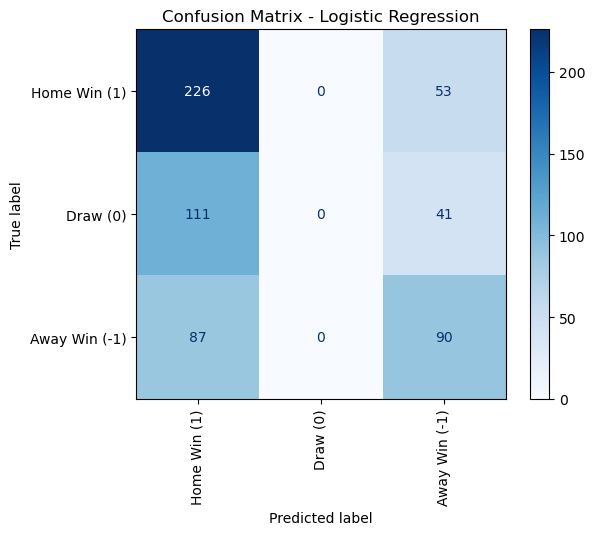

In [125]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])

# Plot the confusion matrix
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.ax_.set_title("Confusion Matrix - Logistic Regression")
plt.show()

In [126]:
# print the results of the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[226   0  53]
 [111   0  41]
 [ 87   0  90]]


## Initial Analysis

Performance of 51.9% means the correct result is predicteed just over half the time, better than chance (33%) and this performance is dominated by its correct prediction of home wins:
- recall score of 0.81 for home wins means 81% of home wins were correctly identified. The precision is significantly lower.

## Optimization - Improving on the first run (51.9%)

Ways we can improve the performance are:
- Fix the class imbalance - resample so that it is not nearly half home wins in the sample
- test the model without the prior probabilities - we may gain more in the draw and away prediction by sacrificing some home win bias in the model.
- Regularization
- Cross-validation

### Optimization - fixing class imbalance by sampling methods e.g. SMOTE

We can try to fix the home win bias by under sampling home wins or oversampling the minority classes (e.g. SMOTE)

Class distribution after SMOTE:
Result
-1    1111
 1    1111
 0    1111
Name: count, dtype: int64
SMOTE Logistic Regression:
Accuracy: 0.5115131578947368
              precision    recall  f1-score   support

          -1       0.46      0.54      0.50       177
           0       0.36      0.32      0.34       152
           1       0.62      0.60      0.61       279

    accuracy                           0.51       608
   macro avg       0.48      0.48      0.48       608
weighted avg       0.51      0.51      0.51       608



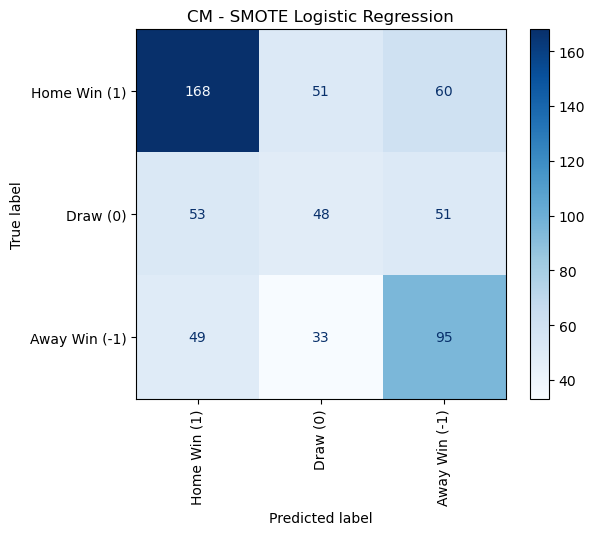

In [127]:
# SMOTE - minority class oversampling

from imblearn.over_sampling import SMOTE

# Step 1: Split data into features (X) and target (y)
X = df.drop('Result', axis=1)
y = df['Result']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Apply SMOTE to the training data
smote = SMOTE(random_state=42) # instantiate SMOTE object
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Step 3: Train Logistic Regression
logistic_model_balanced = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logistic_model_balanced.fit(X_train_balanced, y_train_balanced)

# Step 4: Evaluate the model
y_pred_balanced = logistic_model_balanced.predict(X_test)

# Accuracy and classification report
print("SMOTE Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
cm_balanced = confusion_matrix(y_test, y_pred_balanced, labels=[1, 0, -1])
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])
disp_balanced.plot(cmap='Blues', xticks_rotation='vertical')
disp_balanced.ax_.set_title("CM - SMOTE Logistic Regression")
plt.show()


#### Resuls of SMOTE

- 51.15% predictions correct (slightly worse than vanilla logistic reg.)
- More or less random chance predicting draws
- Virtually the same with away wins

F1 Score of 0.48 improves on the original of 0.38. This reflects better balance (less home win bias) across all three classes even if overall performance is slightly lower.

The ability to predict draws at chance does not make up for the reduced performance of the home wins not being picked up more.

### Optimization - Hyperparameter tuning

In [128]:
logistic_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',  # Automatically balances weights
    random_state=42
)
logistic_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

In [129]:
# hyperparameter tuning with cross-validation

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'class_weight': [None, 'balanced']  # Test both balanced and unbalanced
}

grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)



Best Parameters: {'C': 0.01, 'class_weight': None}
Best Cross-Validated Accuracy: 0.5291978266196837


Optimized Logistic Regression:
Accuracy: 0.5230263157894737
              precision    recall  f1-score   support

          -1       0.50      0.50      0.50       177
           0       0.00      0.00      0.00       152
           1       0.53      0.82      0.65       279

    accuracy                           0.52       608
   macro avg       0.34      0.44      0.38       608
weighted avg       0.39      0.52      0.44       608



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


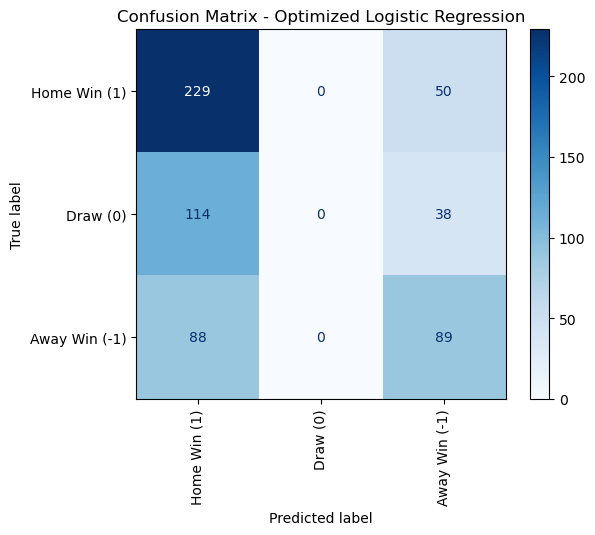

In [130]:
best_logistic_model = grid_search.best_estimator_

# Predictions
y_pred_optimized = best_logistic_model.predict(X_test)

# Accuracy and classification report
print("Optimized Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimized))
print(classification_report(y_test, y_pred_optimized))

# Confusion matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized, labels=[1, 0, -1])
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])
disp_optimized.plot(cmap='Blues', xticks_rotation='vertical')
disp_optimized.ax_.set_title("Confusion Matrix - Optimized Logistic Regression")
plt.show()


#### Analysis

We have added about 0.5% performance from this, it's still barely moving and there's no ability to predict draws

### Removing the prior probabilities - are they helping the model or biasing too much?

In [131]:
df.sample(5)

,rating_diff,net_goals_diff,p(Home),p(Draw),p(Away),Result
228,-1.177570,-0.023299,0.457,0.258,0.285,-1
71,0.695658,1.700824,0.457,0.258,0.285,1
518,-1.045858,-1.607628,0.457,0.258,0.285,0
1674,-1.909299,-0.034948,0.457,0.258,0.285,0
2603,0.095640,-0.512577,0.457,0.258,0.285,0


In [132]:
# make a new dataframe sample without the priors p(home win), p(draw), p(away win)
df_no_prior = df.drop(['p(Home)', 'p(Draw)', 'p(Away)'], axis=1)

In [133]:
df_no_prior.sample(5)

,rating_diff,net_goals_diff,Result
2836,-0.358032,0.524227,1
203,-1.001954,0.244639,1
1086,-1.177570,-1.199896,0
905,0.754197,-0.081546,-1
2216,-1.470261,-0.873711,0


In [134]:
# scaling

from sklearn.preprocessing import StandardScaler

# Scale only the non-probability features in manual_run_prem
scaler = StandardScaler()
features_to_scale = ['rating_diff', 'net_goals_diff']
df_no_prior[features_to_scale] = scaler.fit_transform(df_no_prior[features_to_scale])

In [135]:
# split into X and y
X = df_no_prior.drop('Result', axis=1)
y = df_no_prior['Result']

In [136]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
# train the logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

In [138]:
# Evaluate the model
y_pred = logistic_model.predict(X_test)
print("Manual Run Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Manual Run Logistic Regression:
Accuracy: 0.49835526315789475
              precision    recall  f1-score   support

          -1       0.45      0.52      0.48       177
           0       0.33      0.30      0.31       152
           1       0.62      0.59      0.61       279

    accuracy                           0.50       608
   macro avg       0.47      0.47      0.47       608
weighted avg       0.50      0.50      0.50       608



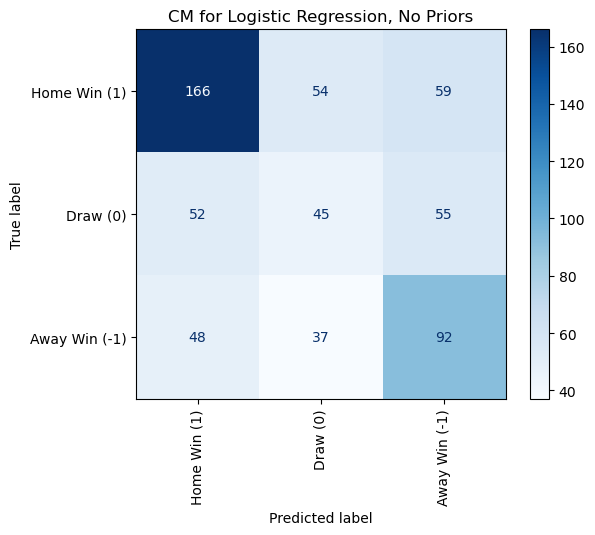

In [139]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])

# Plot the confusion matrix
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.ax_.set_title("CM for Logistic Regression, No Priors")
plt.show()

#### Analysis

- The model is still performing best with home wins but much less so than with the priors
- Draw performance is still effectively just random chance
- mediocre performance on away wins

## First run Optimization - Conclusions

We achieved marginal improvements with a grid search of hyperparameters and cross-validation, about 0.5-1%

The different approaches only seemed to take away some of the bias of home wins and instead gave the model the ability to predict draws no better than chance. Inclusion of the Bayesian priors was improving the model particularly in the home wins prediction but it 

The initial results seem to have hit a ceiling in the low 50% where a bias towards home wins was driving most of the performance above random chance. This was overcompensating for completely avoiding draw predictions.